# Code for Hierarchical Clustering to obtain labels (suitability category)

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [30]:
# Set seed for whole notebook
import random
random.seed(10)

In [31]:
#Loading locational dataset
df = pd.read_csv('final-scaled-df.csv', index_col='FIPS')
df.head(20)

,Biomass,Power,Water Availability,Log_Bio,Log_Water,Log_Power,Income,DSCI,PQ1,PQ2,PQ3,PQ4,TQ1,TQ2,TQ3,TQ4,Forest,Agriculture,Watershed
FIPS,,,,,,,,,,,,,,,,,,,
51001,0.185901,0.601097,0.020793,0.606148,0.417871,0.931630,0.075854,0.148920,0.319901,0.435870,0.410805,0.412876,0.398849,0.223717,0.178736,0.296552,0.064338,0.289624,1
51003,0.354645,0.494455,0.157825,0.754033,0.718885,0.000000,0.108095,0.182011,0.281478,0.361577,0.330150,0.398268,0.652957,0.669414,0.672845,0.580575,0.679813,0.081093,1
51005,0.654945,0.494455,0.083128,0.898739,0.622105,0.000000,0.187226,0.147870,0.208440,0.382735,0.309672,0.361536,0.590581,0.651482,0.660489,0.531379,0.897165,0.020858,1
51007,0.648261,0.515919,0.018988,0.896297,0.404927,0.861198,0.157467,0.144258,0.319836,0.347694,0.488828,0.370654,0.753323,0.808243,0.809483,0.716207,0.651586,0.155517,1
51009,0.236541,0.502679,0.145085,0.660592,0.706138,0.819049,0.184217,0.145333,0.205452,0.416978,0.325681,0.367647,0.499006,0.525380,0.539368,0.463678,0.770831,0.072140,1
51011,0.099752,0.516467,0.082587,0.471095,0.621123,0.862305,0.140248,0.158561,0.278259,0.427413,0.398133,0.403431,0.427002,0.337238,0.280747,0.347356,0.662506,0.159655,1
51013,0.101754,0.494455,0.023823,0.475250,0.437398,0.000000,0.142115,0.105105,0.229655,0.409510,0.284420,0.314118,0.436525,0.430658,0.397845,0.371264,0.089268,0.001349,1
51015,0.421279,0.494455,0.126500,0.794329,0.685401,0.000000,0.197927,0.147820,0.225123,0.379990,0.321457,0.383072,0.615071,0.686479,0.682759,0.561379,0.582228,0.137797,1
51017,0.165266,0.000000,0.098558,0.579941,0.647728,0.000000,0.382682,0.130588,0.262562,0.372108,0.370891,0.394608,0.681005,0.768185,0.779741,0.641724,0.899831,0.020852,1


In [32]:
TEST_RATIO = 0.2
BATCH_SIZE = 64

size_all = len(df)

# training/val/test dataset
size_train = size_all - 6
size_val = int(size_train * TEST_RATIO)
size_train_sub = size_train - size_val

# split data into train and test
# Test = 6 counties of interst: Accomack, Fauquier, Greensville, Hanover, Rockingham, Wise
dataset_val = df.loc[[51001, 51061, 51081, 51085, 51165, 51195]]

# Train = all except 6 counties of interest
dataset_train = df.drop([51001, 51061, 51081, 51085, 51165, 51195])


# Reforestation Clustering

In [33]:
cols = ['Income', 'DSCI', 'PQ1', 'PQ2', 'PQ3', 'PQ4', 'TQ1', 'TQ2', 'TQ3', 'TQ4', 'Forest', 
        'Agriculture', 'Biomass', 'Power', 'Water Availability', 'Watershed',
       'Log_Bio','Log_Water','Log_Power']
cols_rf = ['PQ1', 'PQ2', 'PQ3', 'PQ4', 'TQ1', 'TQ2', 'TQ3', 'TQ4', 'Forest','Water Availability', 'Log_Water']
cols_ew = ['PQ1', 'PQ2', 'PQ3', 'PQ4', 'TQ1', 'TQ2', 'TQ3', 'TQ4', 'Income', 'Power', 'Log_Power', 'Agriculture']
cols_bio = ['PQ1', 'PQ2', 'PQ3', 'PQ4', 'TQ1', 'TQ2', 'TQ3', 'TQ4', 'Income', 'Biomass', 'Log_Bio','Agriculture']

# Using the elbow method to determine the k value to be applied
k_rng = range(1, 10)
sse = []
for k in k_rng:
    km = KMeans(n_clusters=k, n_init=10)
    km.fit(df[['PQ1', 'PQ2', 'PQ3', 'PQ4', 'TQ1', 'TQ2', 'TQ3', 'TQ4', 'Forest','Log_Water']])
    sse.append(km.inertia_)

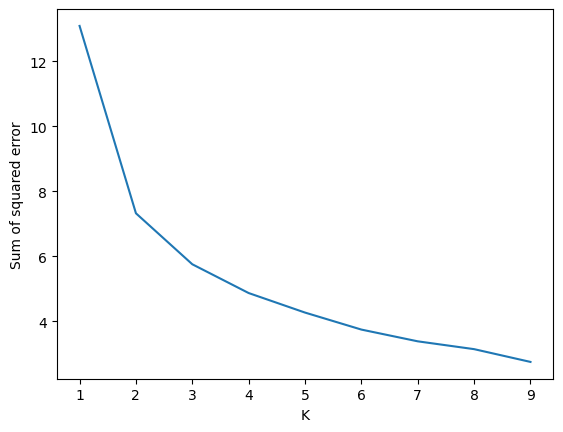

In [34]:
# Plot to obtain elbow
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng, sse)

In [35]:
# create clusters using k value = 4
hc = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'ward')

In [36]:
# Determining mean cluster characterisitics REFORESTATION
y_hc = hc.fit_predict(dataset_train[cols_rf])
dataset_train['Reforest'] = y_hc
dataset_train.sort_values("Reforest", inplace = True, ascending=True)

#average input vars by cluster
df_rfcluster = dataset_train.groupby('Reforest').mean()


# Determining mean cluster characterisitics ENHANCED WEATHERING
y_hc = hc.fit_predict(dataset_train[cols_ew])
dataset_train['EW'] = y_hc
dataset_train.sort_values("EW", inplace = True, ascending=True)

#average input vars by cluster
df_ewcluster = dataset_train.groupby('EW').mean()


# Determining mean cluster characterisitics BIOCHAR
y_hc = hc.fit_predict(dataset_train[cols_bio])
dataset_train['Biochar'] = y_hc
dataset_train.sort_values("Biochar", inplace = True, ascending=True)

#average input vars by cluster
df_biocluster = dataset_train.groupby('Biochar').mean()

/Users/hananur/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/hananur/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/hananur/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


<Axes: ylabel='Biochar'>

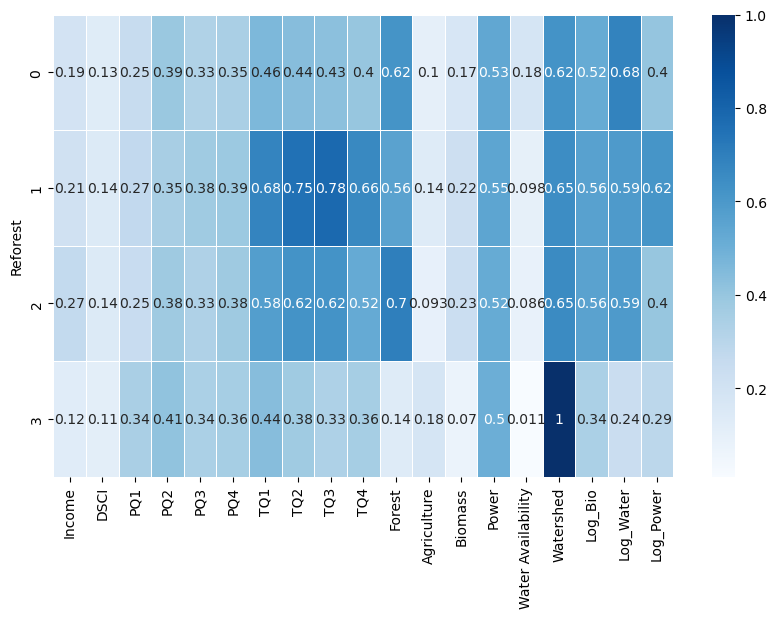

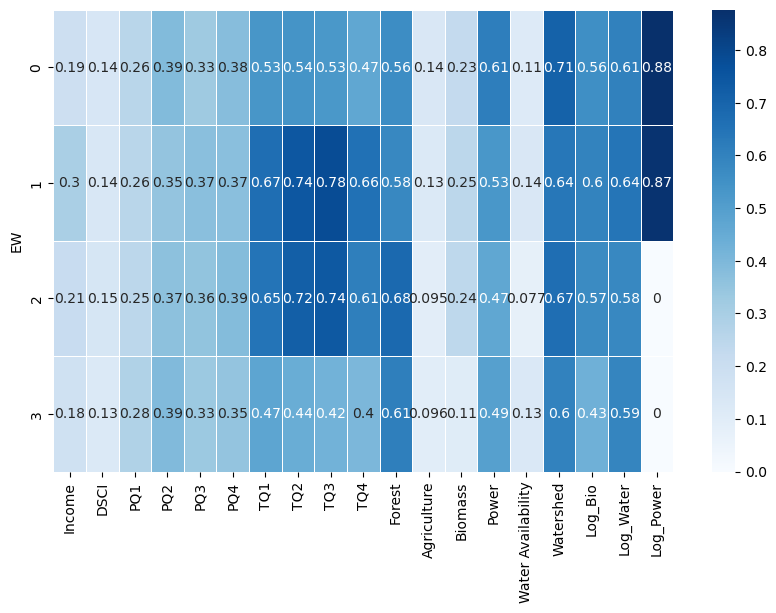

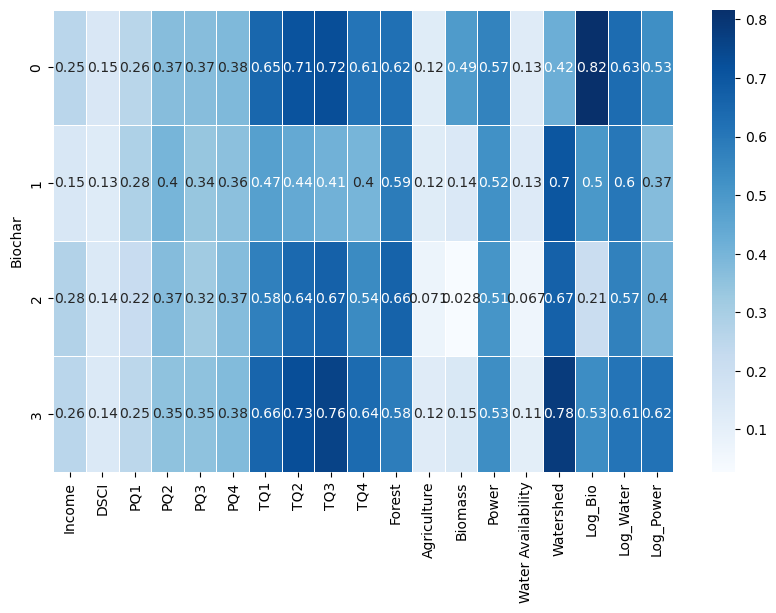

In [37]:
#Heatmap of cluster characteristics reforestation
plt.figure(figsize=(10,6))
sns.heatmap(df_rfcluster[cols], annot=True, cmap="Blues", linewidths=.5)

plt.figure(figsize=(10,6))
sns.heatmap(df_ewcluster[cols], annot=True, cmap="Blues", linewidths=.5)

plt.figure(figsize=(10,6))
sns.heatmap(df_biocluster[cols], annot=True, cmap="Blues", linewidths=.5)

In [38]:
# see how clusters are distributed
dataset_train['Reforest'].value_counts()

Reforest
1    31
2    26
0    24
3     3
Name: count, dtype: int64

In [39]:
dataset_train['EW'].value_counts()

EW
0    24
1    22
3    20
2    18
Name: count, dtype: int64

In [40]:
dataset_train['Biochar'].value_counts()

Biochar
1    30
3    23
0    19
2    12
Name: count, dtype: int64

In [41]:
# Look at counties in smallest cluster
dataset_train[dataset_train['Reforest'] == 3]

,Biomass,Power,Water Availability,Log_Bio,Log_Water,Log_Power,Income,DSCI,PQ1,PQ2,...,TQ1,TQ2,TQ3,TQ4,Forest,Agriculture,Watershed,Reforest,EW,Biochar
FIPS,,,,,,,,,,,,,,,,,,,,,
51115,0.006277,0.494455,0.000000,0.076886,0.000000,0.00000,0.131867,0.118457,0.362594,0.415861,...,0.411094,0.293565,0.254598,0.315172,0.224077,0.094584,1,3,3,1
51013,0.101754,0.494455,0.023823,0.475250,0.437398,0.00000,0.142115,0.105105,0.229655,0.409510,...,0.436525,0.430658,0.397845,0.371264,0.089268,0.001349,1,3,3,1
51131,0.100844,0.519490,0.007939,0.473371,0.285964,0.86796,0.099351,0.117189,0.439573,0.415893,...,0.467713,0.404628,0.346264,0.386092,0.098323,0.449594,1,3,0,1


# Label the clusters as suitability levels

In [42]:
# Maybe redo if we can get more data and redo clusters

# 0 = highly suitable (most forest land, mild summer temps, warm winter temps, faitly high precip, high income, avg drought)
# 2 = suitable (high income, high summer and wimter temps, high rain, good about of forest)
# 1 = possible (lots of forest land, slightly cold, lots of rain, not the best income)
# 3 = unsuitable (too cold, too little forest land, low income)

# Supervised ML for suitability prediction

# Random Forest

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9, 6)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [58]:
# Reading data
# df = pd.read_csv("Labelled Normalised DACCS data.csv")

In [59]:
# creating input identity
sub_df = dataset_train[cols]
X = sub_df
y = dataset_train[['Reforest','EW','Biochar']]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)

In [60]:
X_train_rf = X_train[cols_rf]
X_train_ew = X_train[cols_ew]
X_train_bio = X_train[cols_bio]

X_test_rf = X_test[cols_rf]
X_test_ew = X_test[cols_ew]
X_test_bio = X_test[cols_bio]

y_train_rf = y_train[['Reforest']]
y_train_ew = y_train[['EW']]
y_train_bio = y_train[['Biochar']]

y_test_rf = y_test[['Reforest']]
y_test_ew = y_test[['EW']]
y_test_bio = y_test[['Biochar']]

In [47]:
y_train['Reforest'].value_counts()

Reforest
1    23
2    22
0    19
3     3
Name: count, dtype: int64

In [48]:
y_test['Biochar'].value_counts()

Biochar
3    8
1    5
2    3
0    1
Name: count, dtype: int64

In [49]:
# creating Model (with 100 trees)
rf_rf = RandomForestClassifier(n_estimators=100)
rf_ew = RandomForestClassifier(n_estimators=100)
rf_bio = RandomForestClassifier(n_estimators=100)

In [50]:
# Fitting training data
rf_rf.fit(X_train_rf, y_train_rf)
rf_ew.fit(X_train_ew, y_train_ew)
rf_bio.fit(X_train_bio, y_train_bio)

/Users/hananur/anaconda3/lib/python3.10/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/hananur/anaconda3/lib/python3.10/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/hananur/anaconda3/lib/python3.10/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

In [51]:
# see which counties are in test
y_test_rf.index

Index([51083, 51193, 51155, 51197, 51119, 51099, 51107, 51011, 51041, 51139,
       51017, 51057, 51105, 51179, 51157, 51177, 51089],
      dtype='int64', name='FIPS')

In [52]:
#make predictions
y_pred_rf = rf_rf.predict(X_test_rf)
y_pred_ew = rf_ew.predict(X_test_ew)
y_pred_bio = rf_bio.predict(X_test_bio)

#for pred_label, true_label, index in zip(y_pred_ew, y_test_ew, y_test_ew.index):
 #   print(pred_label, true_label, index)

In [53]:
# To get model performance 
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
cr1 = classification_report(y_test_rf, y_pred_rf)
cr2 = classification_report(y_test_ew, y_pred_ew)
cr3 = classification_report(y_test_bio, y_pred_bio)
print('Reforestation:\n' , cr1, '\n')
print('EW:\n' , cr2, '\n')
print('Biochar:\n' , cr3, '\n')

Reforestation:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.78      0.88      0.82         8
           2       0.67      0.50      0.57         4

    accuracy                           0.82        17
   macro avg       0.81      0.79      0.80        17
weighted avg       0.82      0.82      0.82        17
 

EW:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17
 

Biochar:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1

In [54]:
print("Reforestation Accuracy:", accuracy_score(y_test_rf, y_pred_rf), '\n')
print("EW Accuracy:", accuracy_score(y_test_ew, y_pred_ew), '\n')
print("Biochar Accuracy:", accuracy_score(y_test_bio, y_pred_bio), '\n')

Reforestation Accuracy: 0.8235294117647058 

EW Accuracy: 1.0 

Biochar Accuracy: 0.9411764705882353 



In [55]:
# Determining feature importance (Model Interpretation)
feature_imp_rf = pd.DataFrame(rf_rf.feature_importances_,index= X_train_rf.columns,
columns=['importance']).sort_values('importance',ascending=False)
print('Reforestation:\n' , feature_imp_rf , "\n")

feature_imp_ew = pd.DataFrame(rf_ew.feature_importances_,index= X_train_ew.columns,
columns=['importance']).sort_values('importance',ascending=False)
print('Enhanced Weathering:\n' , feature_imp_ew , "\n")

feature_imp_bio = pd.DataFrame(rf_bio.feature_importances_,index= X_train_bio.columns,
columns=['importance']).sort_values('importance',ascending=False)
print('Biochar:\n' , feature_imp_bio , "\n")

Reforestation:
                     importance
TQ4                   0.210155
TQ2                   0.172712
TQ1                   0.159411
Forest                0.102659
TQ3                   0.101745
Log_Water             0.065186
PQ4                   0.045878
PQ2                   0.041336
Water Availability    0.036666
PQ3                   0.033916
PQ1                   0.030336 

Enhanced Weathering:
              importance
Log_Power      0.223946
Power          0.191617
TQ3            0.136510
TQ4            0.124230
TQ2            0.113265
TQ1            0.062240
Income         0.030320
PQ4            0.029050
PQ2            0.028226
Agriculture    0.023257
PQ1            0.020929
PQ3            0.016409 

Biochar:
              importance
Log_Bio        0.190802
Biomass        0.175100
TQ2            0.139271
TQ4            0.138413
TQ3            0.130343
Income         0.045829
TQ1            0.043881
PQ1            0.031969
PQ2            0.028850
PQ3            0.026159


<Axes: >

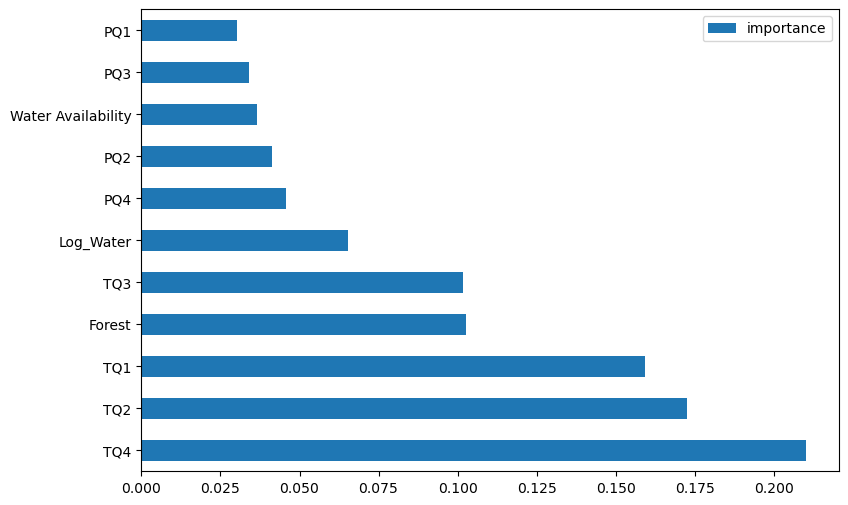

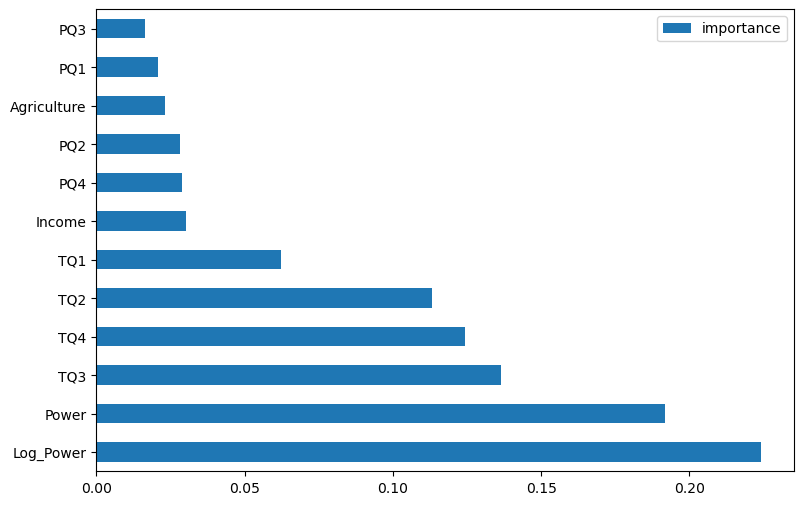

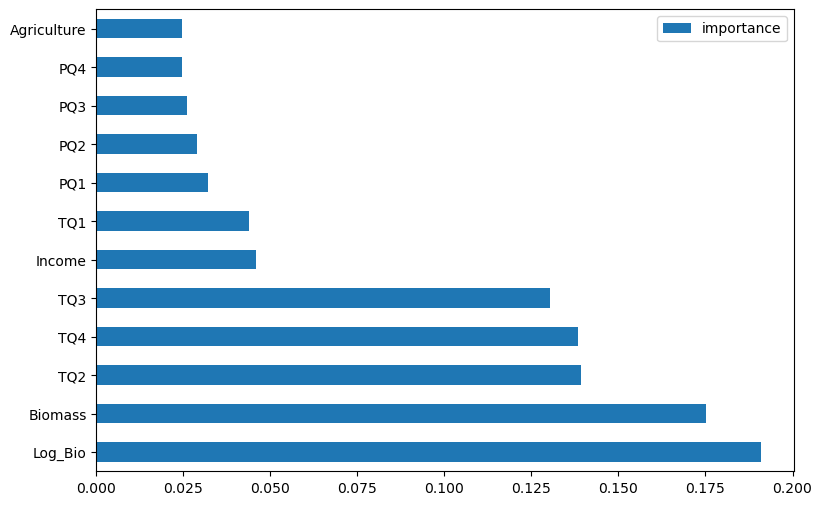

In [56]:
#Feature importance visualisation
feature_imp_rf.plot(kind='barh') #reforest
feature_imp_ew.plot(kind='barh') #ew
feature_imp_bio.plot(kind='barh') #biochar

# Logistic Regression

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [30]:
logreg_model_rf = LogisticRegression()
logreg_model_ew = LogisticRegression()
logreg_model_bio = LogisticRegression()

logreg_model_rf.fit(X_train_rf, y_train_rf)
logreg_model_ew.fit(X_train_ew, y_train_ew)
logreg_model_bio.fit(X_train_bio, y_train_bio)

# predict
y_pred_rf = logreg_model_rf.predict(X_test_rf)
y_pred_ew = logreg_model_ew.predict(X_test_ew)
y_pred_bio = logreg_model_bio.predict(X_test_bio)

/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [31]:
# To get model performance Reforest
from sklearn.metrics import classification_report
cr1 = classification_report(y_test_rf, y_pred_rf)
cr2 = classification_report(y_test_ew, y_pred_ew)
cr3 = classification_report(y_test_bio, y_pred_bio)
print('Reforestation:\n' , cr1, '\n')
print('EW:\n' , cr2, '\n')
print('Biochar:\n' , cr3, '\n')

Reforestation:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.89      1.00      0.94         8
           2       1.00      0.75      0.86         4

    accuracy                           0.94        17
   macro avg       0.96      0.92      0.93        17
weighted avg       0.95      0.94      0.94        17
 

EW:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17
 

Biochar:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1

In [32]:
print("Reforestation Accuracy:", accuracy_score(y_test_rf, y_pred_rf), '\n')
print("EW Accuracy:", accuracy_score(y_test_ew, y_pred_ew), '\n')
print("Biochar Accuracy:", accuracy_score(y_test_bio, y_pred_bio), '\n')

Reforestation Accuracy: 0.9411764705882353 

EW Accuracy: 1.0 

Biochar Accuracy: 0.9411764705882353 



In [33]:
feature_names_rf = X_train_rf.columns
feature_names_ew = X_train_ew.columns
feature_names_bio = X_train_bio.columns

coeffs_rf = pd.DataFrame({'Feature': feature_names_rf, 'Coefficient': logreg_model_rf.coef_[0]})
coeffs_ew = pd.DataFrame({'Feature': feature_names_ew, 'Coefficient': logreg_model_ew.coef_[0]})
coeffs_bio = pd.DataFrame({'Feature': feature_names_bio, 'Coefficient': logreg_model_bio.coef_[0]})

coeffs_rf['Abs_Coefficient'] = abs(coeffs_rf['Coefficient'])
coeffs_ew['Abs_Coefficient'] = abs(coeffs_ew['Coefficient'])
coeffs_bio['Abs_Coefficient'] = abs(coeffs_bio['Coefficient'])

coeffs_rf.sort_values(by='Abs_Coefficient', ascending=False, inplace=True)
coeffs_ew.sort_values(by='Abs_Coefficient', ascending=False, inplace=True)
coeffs_bio.sort_values(by='Abs_Coefficient', ascending=False, inplace=True)

<Axes: ylabel='Feature'>

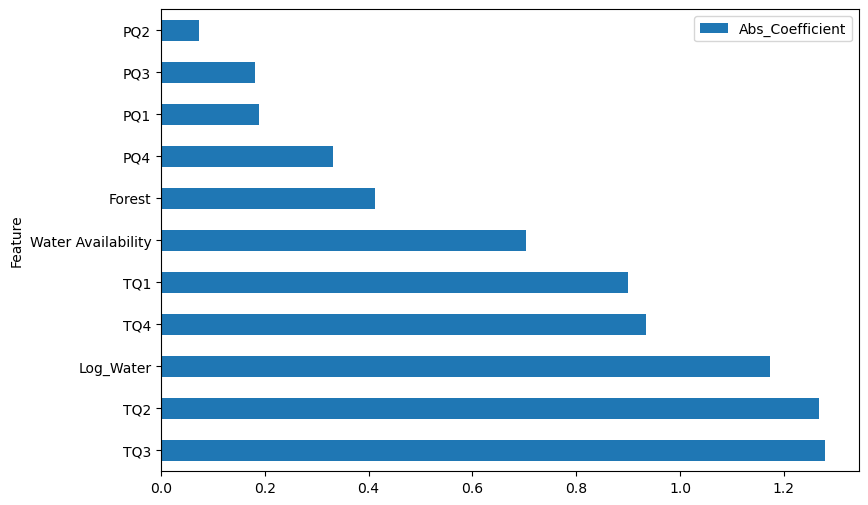

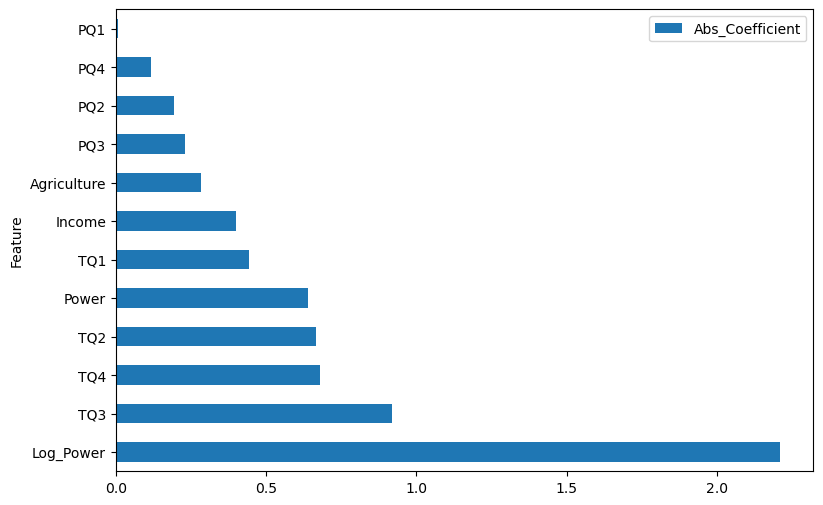

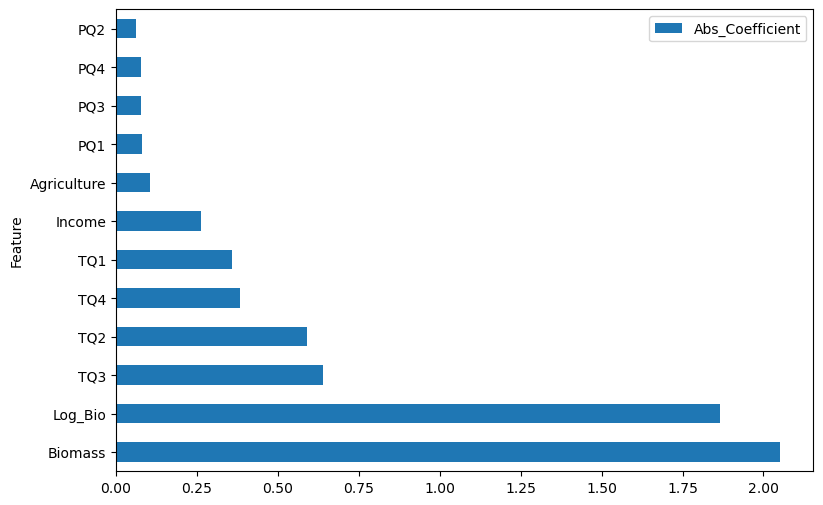

In [34]:
#Feature importance visualisation
coeffs_rf.plot(kind='barh', x='Feature', y='Abs_Coefficient')
coeffs_ew.plot(kind='barh', x='Feature', y='Abs_Coefficient')
coeffs_bio.plot(kind='barh', x='Feature', y='Abs_Coefficient')

# Descision Tree

In [35]:
# supervised learning method
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

In [36]:
dt_model_rf = DecisionTreeClassifier(random_state=0)
dt_model_ew = DecisionTreeClassifier(random_state=0)
dt_model_bio = DecisionTreeClassifier(random_state=0)

dt_model_rf.fit(X_train_rf, y_train_rf)
dt_model_ew.fit(X_train_ew, y_train_ew)
dt_model_bio.fit(X_train_bio, y_train_bio)

y_pred_rf = dt_model_rf.predict(X_test_rf)
y_pred_ew = dt_model_ew.predict(X_test_ew)
y_pred_bio = dt_model_bio.predict(X_test_bio)

print('Reforestation:\n',classification_report(y_test_rf, y_pred_rf),'\n')
print('EW:\n',classification_report(y_test_ew, y_pred_ew),'\n')
print('Biochar:\n',classification_report(y_test_bio, y_pred_bio),'\n')

Reforestation:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.88      0.88      0.88         8
           2       1.00      0.75      0.86         4

    accuracy                           0.88        17
   macro avg       0.90      0.88      0.88        17
weighted avg       0.89      0.88      0.88        17
 

EW:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.86      0.92         7
           2       0.67      1.00      0.80         2
           3       1.00      0.67      0.80         3

    accuracy                           0.88        17
   macro avg       0.88      0.88      0.86        17
weighted avg       0.91      0.88      0.88        17
 

Biochar:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      1.00      1

In [37]:
print("Reforestation Accuracy:", accuracy_score(y_test_rf, y_pred_rf), '\n')
print("EW Accuracy:", accuracy_score(y_test_ew, y_pred_ew), '\n')
print("Biochar Accuracy:", accuracy_score(y_test_bio, y_pred_bio), '\n')

Reforestation Accuracy: 0.8823529411764706 

EW Accuracy: 0.8823529411764706 

Biochar Accuracy: 0.8235294117647058 



In [38]:
print('Reforestation:\n',cross_val_score(dt_model_rf, X_train_rf, y_train_rf, cv=10),'\n')
print('EW:\n',cross_val_score(dt_model_ew, X_train_ew, y_train_ew, cv=10),'\n')
print('Biochar:\n',cross_val_score(dt_model_bio, X_train_bio, y_train_bio, cv=10),'\n')

Reforestation:
 [0.71428571 0.71428571 0.85714286 1.         0.85714286 0.85714286
 1.         1.         0.66666667 1.        ] 

EW:
 [1.         1.         1.         1.         0.85714286 1.
 1.         1.         0.66666667 1.        ] 

Biochar:
 [0.85714286 0.85714286 1.         1.         0.57142857 0.71428571
 0.71428571 0.83333333 1.         0.83333333] 



/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


# KNN

In [39]:
from sklearn.neighbors import KNeighborsClassifier
n_acc_rf = [0]*11
n_acc_ew = [0]*11
n_acc_bio = [0]*11

print('Reforestation:')
for n in [1,2,3,4,5,6,7,8,9,10]:
    neigh_rf = KNeighborsClassifier(n_neighbors=n)
    
    neigh_rf.fit(X_train_rf, y_train_rf)
    
    preds_rf = neigh_rf.predict(X_test_rf)
    
    correct_rf = 0
    
    for i in range(len(preds_rf)):
        if preds_rf[i]==y_test_rf.values[i]:
            correct_rf += 1
    acc_rf = correct_rf/len(preds_rf)
    n_acc_rf[n] = acc_rf
    print(f'{n} neighbors - validation accuracy: {round(acc_rf, 5)} {correct_rf}/{len(preds_rf)}')
    
print('\nEW:')   
for n in [1,2,3,4,5,6,7,8,9,10]:
    neigh_ew = KNeighborsClassifier(n_neighbors=n)
    
    neigh_ew.fit(X_train_ew, y_train_ew)
    
    preds_ew = neigh_ew.predict(X_test_ew)
    
    correct_ew = 0
    
    for i in range(len(preds_ew)):
        if preds_ew[i]==y_test_ew.values[i]:
            correct_ew += 1
    acc_ew = correct_ew/len(preds_ew)
    n_acc_ew[n] = acc_ew
    print(f'{n} neighbors - validation accuracy: {round(acc_ew, 5)} {correct_ew}/{len(preds_ew)}')

print('\nBiochar:')
for n in [1,2,3,4,5,6,7,8,9,10]:
    neigh_bio = KNeighborsClassifier(n_neighbors=n)
    
    neigh_bio.fit(X_train_bio, y_train_bio)
    
    preds_bio = neigh_bio.predict(X_test_bio)
    
    correct_bio = 0
    
    for i in range(len(preds_bio)):
        if preds_bio[i]==y_test_bio.values[i]:
            correct_bio += 1
    acc_bio = correct_bio/len(preds_bio)
    n_acc_bio[n] = acc_bio
    print(f'{n} neighbors - validation accuracy: {round(acc_bio, 5)} {correct_bio}/{len(preds_bio)}')

Reforestation:
1 neighbors - validation accuracy: 0.94118 16/17
2 neighbors - validation accuracy: 0.88235 15/17
3 neighbors - validation accuracy: 0.94118 16/17
4 neighbors - validation accuracy: 0.94118 16/17
5 neighbors - validation accuracy: 0.94118 16/17
6 neighbors - validation accuracy: 0.94118 16/17
7 neighbors - validation accuracy: 0.94118 16/17
8 neighbors - validation accuracy: 0.94118 16/17
9 neighbors - validation accuracy: 0.94118 16/17
10 neighbors - validation accuracy: 0.94118 16/17

EW:
1 neighbors - validation accuracy: 0.94118 16/17
2 neighbors - validation accuracy: 1.0 17/17
3 neighbors - validation accuracy: 1.0 17/17
4 neighbors - validation accuracy: 0.88235 15/17
5 neighbors - validation accuracy: 1.0 17/17
6 neighbors - validation accuracy: 0.94118 16/17
7 neighbors - validation accuracy: 0.94118 16/17
8 neighbors - validation accuracy: 0.94118 16/17
9 neighbors - validation accuracy: 0.88235 15/17
10 neighbors - validation accuracy: 0.94118 16/17

Biochar:


/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when

Text(0.5, 1.0, 'Biochar Validation Accuracy By Number of Neighbors')

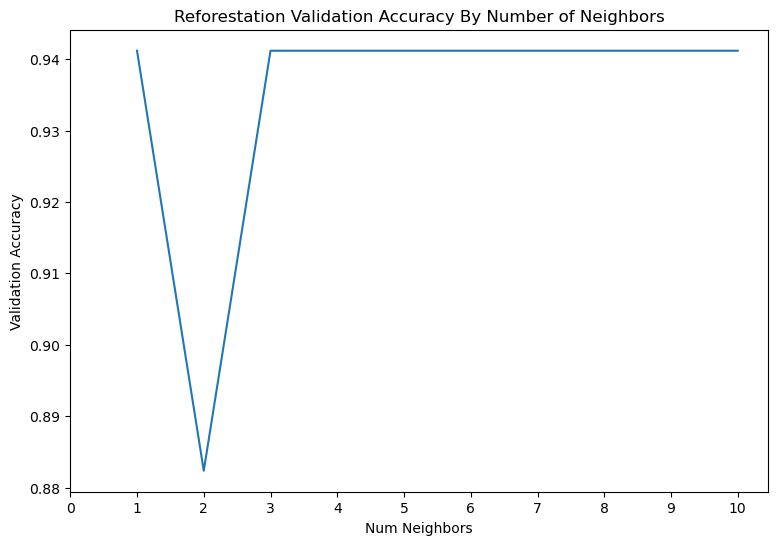

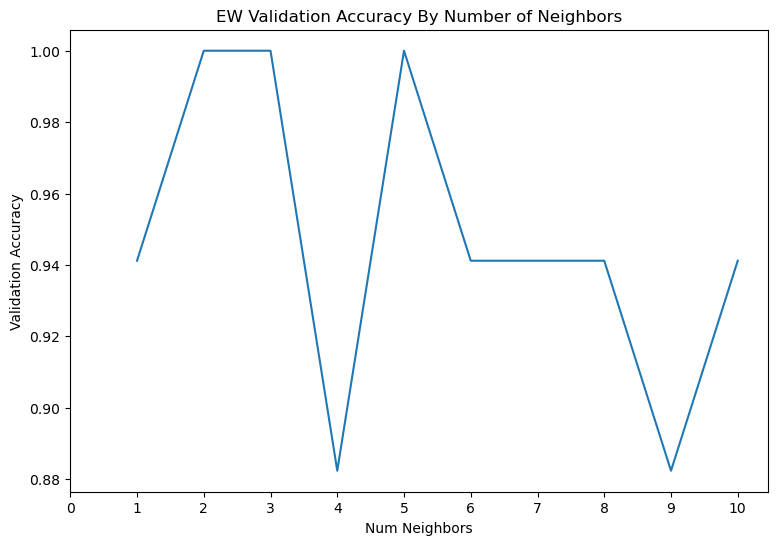

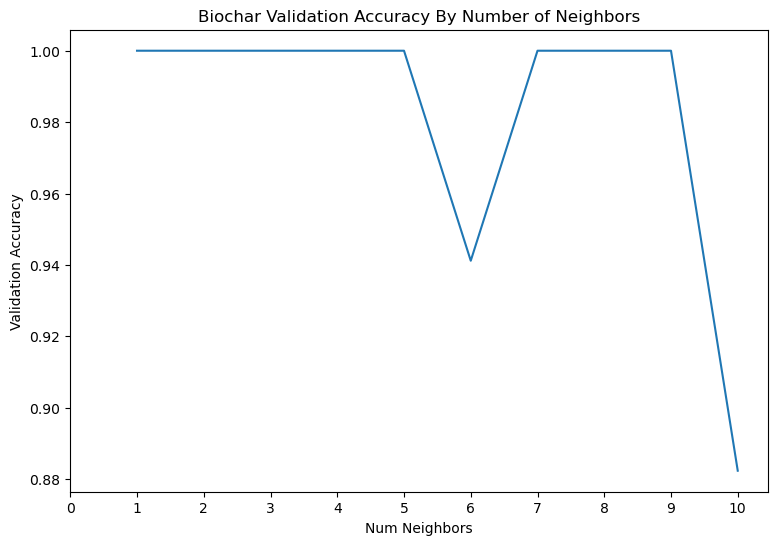

In [40]:
fig, ax = plt.subplots() 
ax.plot([i for i in range(1,len(n_acc_rf))], n_acc_rf[1:])
plt.xlabel('Num Neighbors')
plt.ylabel('Validation Accuracy')
ax.set_xticks(np.arange(len(n_acc_rf)))
plt.title('Reforestation Validation Accuracy By Number of Neighbors')

fig, ax = plt.subplots() 
ax.plot([i for i in range(1,len(n_acc_ew))], n_acc_ew[1:])
plt.xlabel('Num Neighbors')
plt.ylabel('Validation Accuracy')
ax.set_xticks(np.arange(len(n_acc_ew)))
plt.title('EW Validation Accuracy By Number of Neighbors')

fig, ax = plt.subplots() 
ax.plot([i for i in range(1,len(n_acc_bio))], n_acc_bio[1:])
plt.xlabel('Num Neighbors')
plt.ylabel('Validation Accuracy')
ax.set_xticks(np.arange(len(n_acc_bio)))
plt.title('Biochar Validation Accuracy By Number of Neighbors')

In [41]:
neigh_rf = KNeighborsClassifier(n_neighbors=3)
neigh_ew = KNeighborsClassifier(n_neighbors=2)
neigh_bio = KNeighborsClassifier(n_neighbors=3)

neigh_rf.fit(X_train_rf, y_train_rf)
neigh_ew.fit(X_train_ew, y_train_ew)
neigh_bio.fit(X_train_bio, y_train_bio)

y_pred_rf = neigh_rf.predict(X_test_rf)
y_pred_ew = neigh_ew.predict(X_test_ew)
y_pred_bio = neigh_bio.predict(X_test_bio)

print('Reforestation:\n',classification_report(y_test_rf, y_pred_rf),'\n')
print('EW:\n',classification_report(y_test_ew, y_pred_ew),'\n')
print('Biochar:\n',classification_report(y_test_bio, y_pred_bio),'\n')

Reforestation:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.89      1.00      0.94         8
           2       1.00      0.75      0.86         4

    accuracy                           0.94        17
   macro avg       0.96      0.92      0.93        17
weighted avg       0.95      0.94      0.94        17
 

EW:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17
 

Biochar:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1

/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [42]:
print("Reforestation Accuracy:", accuracy_score(y_test_rf, y_pred_rf), '\n')
print("EW Accuracy:", accuracy_score(y_test_ew, y_pred_ew), '\n')
print("Biochar Accuracy:", accuracy_score(y_test_bio, y_pred_bio), '\n')

Reforestation Accuracy: 0.9411764705882353 

EW Accuracy: 1.0 

Biochar Accuracy: 1.0 



# Naive Bayes

In [43]:
from sklearn.naive_bayes import MultinomialNB

naive_bayes_model_rf = MultinomialNB()
naive_bayes_model_ew = MultinomialNB()
naive_bayes_model_bio = MultinomialNB()

naive_bayes_model_rf.fit(X_train_rf, y_train_rf)
naive_bayes_model_ew.fit(X_train_ew, y_train_ew)
naive_bayes_model_bio.fit(X_train_bio, y_train_bio)

y_pred_rf = naive_bayes_model_rf.predict(X_test_rf)
y_pred_ew = naive_bayes_model_ew.predict(X_test_ew)
y_pred_bio = naive_bayes_model_bio.predict(X_test_bio)

print('Reforestation:\n',classification_report(y_test_rf, y_pred_rf),'\n')
print('EW:\n',classification_report(y_test_ew, y_pred_ew),'\n')
print('Biochar:\n',classification_report(y_test_bio, y_pred_bio),'\n')

Reforestation:
               precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.80      1.00      0.89         8
           2       0.33      0.50      0.40         4

    accuracy                           0.65        17
   macro avg       0.71      0.57      0.54        17
weighted avg       0.75      0.65      0.61        17
 

EW:
               precision    recall  f1-score   support

           0       0.42      1.00      0.59         5
           1       0.00      0.00      0.00         7
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3

    accuracy                           0.59        17
   macro avg       0.60      0.75      0.65        17
weighted avg       0.42      0.59      0.47        17
 

Biochar:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.29      1.00      0

/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-

In [44]:
print("Reforestation Accuracy:", accuracy_score(y_test_rf, y_pred_rf), '\n')
print("EW Accuracy:", accuracy_score(y_test_ew, y_pred_ew), '\n')
print("Biochar Accuracy:", accuracy_score(y_test_bio, y_pred_bio), '\n')

Reforestation Accuracy: 0.6470588235294118 

EW Accuracy: 0.5882352941176471 

Biochar Accuracy: 0.29411764705882354 



# Gradient Boost

In [45]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

#fit gradient boosted stumps (trees w depth=1)
clf_rf = GradientBoostingClassifier(n_estimators=100, 
                                 learning_rate=1.0, 
                                 max_depth=1, 
                                 random_state=0).fit(X_train_rf, y_train_rf)
clf_ew = GradientBoostingClassifier(n_estimators=100, 
                                 learning_rate=1.0, 
                                 max_depth=1, 
                                 random_state=0).fit(X_train_ew, y_train_ew)
clf_bio = GradientBoostingClassifier(n_estimators=100, 
                                 learning_rate=1.0, 
                                 max_depth=1, 
                                 random_state=0).fit(X_train_bio, y_train_bio)

/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [46]:
y_pred_rf = clf_rf.predict(X_test_rf)
y_pred_ew = clf_ew.predict(X_test_ew)
y_pred_bio = clf_bio.predict(X_test_bio)

print('Reforestation:\n',classification_report(y_test_rf, y_pred_rf),'\n')
print('EW:\n',classification_report(y_test_ew, y_pred_ew),'\n')
print('Biochar:\n',classification_report(y_test_bio, y_pred_bio),'\n')

Reforestation:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.88      0.88      0.88         8
           2       0.75      0.75      0.75         4

    accuracy                           0.88        17
   macro avg       0.88      0.88      0.88        17
weighted avg       0.88      0.88      0.88        17
 

EW:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.86      0.92         7
           2       0.67      1.00      0.80         2
           3       1.00      0.67      0.80         3

    accuracy                           0.88        17
   macro avg       0.88      0.88      0.86        17
weighted avg       0.91      0.88      0.88        17
 

Biochar:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1

In [47]:
print("Reforestation Accuracy:", accuracy_score(y_test_rf, y_pred_rf), '\n')
print("EW Accuracy:", accuracy_score(y_test_ew, y_pred_ew), '\n')
print("Biochar Accuracy:", accuracy_score(y_test_bio, y_pred_bio), '\n')

Reforestation Accuracy: 0.8823529411764706 

EW Accuracy: 0.8823529411764706 

Biochar Accuracy: 1.0 



In [48]:
feature_imp_rf = pd.DataFrame(clf_rf.feature_importances_,index= X_train_rf.columns, columns=['importance']).sort_values('importance',ascending=False)
feature_imp_ew = pd.DataFrame(clf_ew.feature_importances_,index= X_train_ew.columns, columns=['importance']).sort_values('importance',ascending=False)
feature_imp_bio = pd.DataFrame(clf_bio.feature_importances_,index= X_train_bio.columns, columns=['importance']).sort_values('importance',ascending=False)


print('Reforestation:\n' , feature_imp_rf , "\n")
print('Enhanced Weathering:\n' , feature_imp_ew , "\n")
print('Biochar:\n' , feature_imp_bio , "\n")

Reforestation:
                       importance
TQ4                 5.121563e-01
TQ2                 2.333244e-01
Forest              1.395647e-01
PQ2                 4.147964e-02
Water Availability  3.958568e-02
TQ1                 2.706119e-02
PQ1                 4.257863e-03
PQ4                 2.031219e-03
Log_Water           5.389519e-04
TQ3                 4.990826e-08
PQ3                 3.282322e-08 

Enhanced Weathering:
                importance
TQ3          4.218033e-01
Power        3.068033e-01
Log_Power    1.644414e-01
TQ2          9.070495e-02
Agriculture  1.224898e-02
TQ4          3.843708e-03
Income       9.650902e-05
TQ1          3.941394e-05
PQ1          1.792326e-05
PQ2          3.521318e-07
PQ3          2.508776e-07
PQ4          1.304439e-08 

Biochar:
              importance
TQ3            0.527959
Biomass        0.422259
Income         0.016213
PQ2            0.011522
TQ2            0.009707
TQ4            0.005049
Log_Bio        0.003971
Agriculture    0.00187

<Axes: >

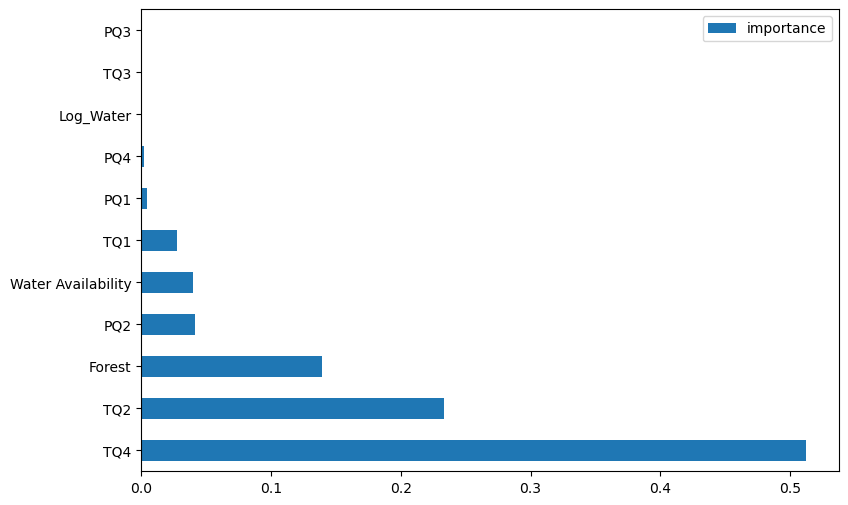

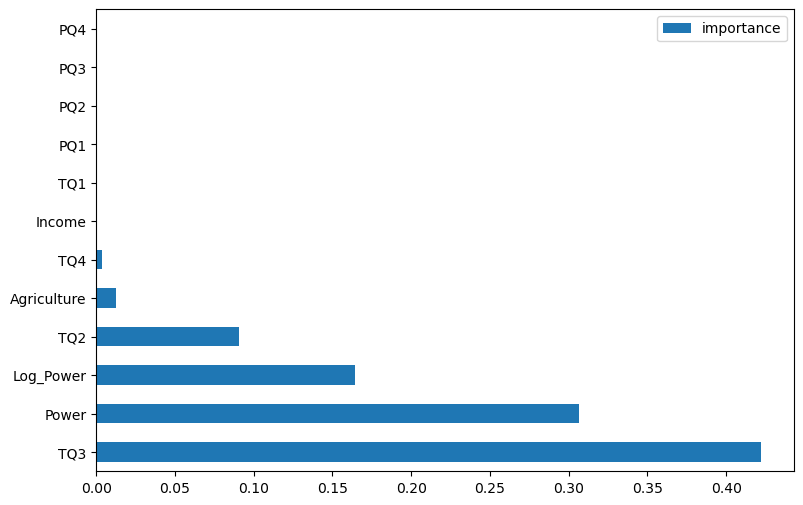

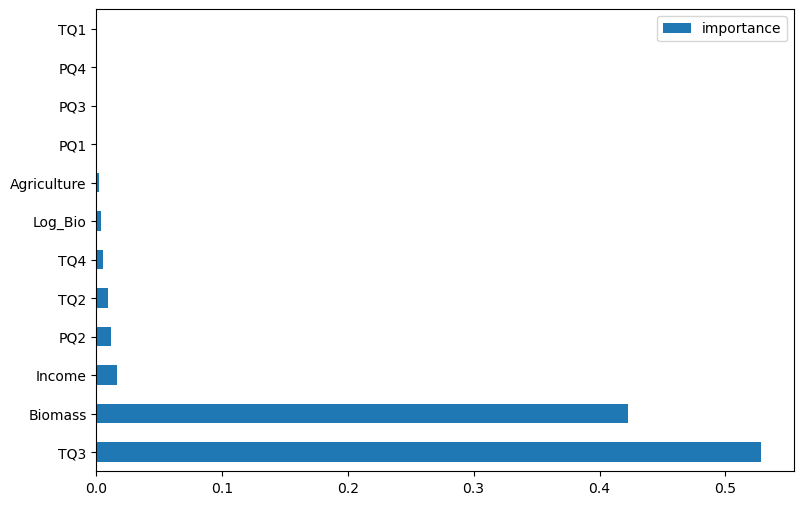

In [49]:
#Feature importance visualisation
feature_imp_rf.plot(kind='barh') #reforest
feature_imp_ew.plot(kind='barh') #ew
feature_imp_bio.plot(kind='barh') #biochar

# Neural Net

## Feed Forward ANN (MLPClassifier from sklearn)

In [50]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

clf_rf = MLPClassifier(random_state=1, max_iter=300).fit(X_train_rf, y_train_rf)
clf_ew = MLPClassifier(random_state=1, max_iter=300).fit(X_train_ew, y_train_ew)
clf_bio = MLPClassifier(random_state=1, max_iter=300).fit(X_train_bio, y_train_bio)

/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Op

In [51]:
clf_rf.predict_proba(X_test_rf)

array([[3.82317134e-02, 7.39491079e-01, 2.13380975e-01, 8.89623301e-03],
       [8.12333586e-02, 6.57774253e-01, 2.37959901e-01, 2.30324866e-02],
       [1.33953862e-01, 3.16460991e-01, 5.25918406e-01, 2.36667419e-02],
       [7.55327934e-01, 1.61507563e-02, 2.00367532e-01, 2.81537783e-02],
       [1.33641797e-03, 9.38687515e-01, 5.08345754e-02, 9.14149209e-03],
       [5.55184467e-02, 5.91471231e-01, 3.39415160e-01, 1.35951625e-02],
       [9.94792565e-01, 9.30579705e-06, 8.75260669e-04, 4.32286900e-03],
       [8.72489715e-01, 2.88588415e-03, 1.06281793e-01, 1.83426077e-02],
       [6.93341539e-01, 1.96808472e-02, 2.49159740e-01, 3.78178744e-02],
       [1.50469527e-02, 6.73940123e-01, 2.99976061e-01, 1.10368639e-02],
       [4.69068814e-02, 3.07729619e-01, 6.39624966e-01, 5.73853319e-03],
       [1.60263785e-02, 7.44423414e-01, 2.22550673e-01, 1.69995340e-02],
       [1.90077956e-02, 7.16611361e-01, 2.55625751e-01, 8.75509268e-03],
       [4.39618090e-02, 7.23760579e-01, 2.22656980e

In [52]:
y_pred_rf = clf_rf.predict(X_test_rf)
y_pred_ew = clf_ew.predict(X_test_ew)
y_pred_bio = clf_bio.predict(X_test_bio)
y_pred_rf

array([1, 1, 2, 0, 1, 1, 0, 0, 0, 1, 2, 1, 1, 1, 2, 1, 0])

In [53]:
y_test_rf

,Reforest
FIPS,
51083,1
51193,1
51155,2
51197,0
51119,1
51099,1
51107,0
51011,0
51041,0


In [54]:
print('Reforestation:\n',classification_report(y_test_rf, y_pred_rf),'\n')
print('EW:\n',classification_report(y_test_ew, y_pred_ew),'\n')
print('Biochar:\n',classification_report(y_test_bio, y_pred_bio),'\n')

Reforestation:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.89      1.00      0.94         8
           2       1.00      0.75      0.86         4

    accuracy                           0.94        17
   macro avg       0.96      0.92      0.93        17
weighted avg       0.95      0.94      0.94        17
 

EW:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       0.67      1.00      0.80         2
           3       1.00      0.67      0.80         3

    accuracy                           0.94        17
   macro avg       0.92      0.92      0.90        17
weighted avg       0.96      0.94      0.94        17
 

Biochar:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1

In [55]:
print("Reforestation Accuracy:", accuracy_score(y_test_rf, y_pred_rf), '\n')
print("EW Accuracy:", accuracy_score(y_test_ew, y_pred_ew), '\n')
print("Biochar Accuracy:", accuracy_score(y_test_bio, y_pred_bio), '\n')

Reforestation Accuracy: 0.9411764705882353 

EW Accuracy: 0.9411764705882353 

Biochar Accuracy: 1.0 



## Simple ANN

In [61]:
# loading everything that might be helpful
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image
import torch
from torch.utils.data import DataLoader, random_split
from torch import Generator
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torch import manual_seed as torch_manual_seed
import random
import numpy as np

from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn

In [62]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [63]:
dataset_val_rf = dataset_val[cols_rf]
dataset_val_ew = dataset_val[cols_ew]
dataset_val_bio = dataset_val[cols_bio]

In [64]:
# Make data into tensor objects
X_train_rf_tensor = torch.tensor(X_train_rf.values, dtype=torch.float32)
X_train_ew_tensor = torch.tensor(X_train_ew.values, dtype=torch.float32)
X_train_bio_tensor = torch.tensor(X_train_bio.values, dtype=torch.float32)

X_test_rf_tensor = torch.tensor(X_test_rf.values, dtype=torch.float32)
X_test_ew_tensor = torch.tensor(X_test_ew.values, dtype=torch.float32)
X_test_bio_tensor = torch.tensor(X_test_bio.values, dtype=torch.float32)

y_train_rf_tensor = torch.tensor(y_train_rf['Reforest'].values, dtype=torch.float32)
y_train_ew_tensor = torch.tensor(y_train_ew['EW'].values, dtype=torch.float32)
y_train_bio_tensor = torch.tensor(y_train_bio['Biochar'].values, dtype=torch.float32)

y_test_rf_tensor = torch.tensor(y_test_rf['Reforest'].values, dtype=torch.float32)
y_test_ew_tensor = torch.tensor(y_test_ew['EW'].values, dtype=torch.float32)
y_test_bio_tensor = torch.tensor(y_test_bio['Biochar'].values, dtype=torch.float32)

# Make test data into tensor objects
X_val_rf_tensor = torch.tensor(dataset_val_rf.values, dtype=torch.float32)
X_val_ew_tensor = torch.tensor(dataset_val_ew.values, dtype=torch.float32)
X_val_bio_tensor = torch.tensor(dataset_val_bio.values, dtype=torch.float32)

In [65]:
#train data
training_data_rf = TensorDataset(X_train_rf_tensor, y_train_rf_tensor)
train_dataloader_rf = DataLoader(training_data_rf, batch_size=64)

training_data_ew = TensorDataset(X_train_ew_tensor, y_train_ew_tensor)
train_dataloader_ew = DataLoader(training_data_ew, batch_size=64)

training_data_bio = TensorDataset(X_train_bio_tensor, y_train_bio_tensor)
train_dataloader_bio = DataLoader(training_data_bio, batch_size=64)


#test data
test_data_rf = TensorDataset(X_test_rf_tensor,  y_test_rf_tensor)
test_dataloader_rf = DataLoader(test_data_rf, batch_size=64)

test_data_ew = TensorDataset(X_test_ew_tensor,  y_test_ew_tensor)
test_dataloader_ew = DataLoader(test_data_ew, batch_size=64)

test_data_bio = TensorDataset(X_test_bio_tensor,  y_test_bio_tensor)
test_dataloader_bio = DataLoader(test_data_bio, batch_size=64)


#validate data
val_data_rf = TensorDataset(X_val_rf_tensor)
val_dataloader_rf = DataLoader(val_data_rf, batch_size=64)

val_data_ew = TensorDataset(X_val_ew_tensor)
val_dataloader_ew = DataLoader(val_data_ew, batch_size=64)

val_data_bio = TensorDataset(X_val_bio_tensor)
val_dataloader_bio = DataLoader(val_data_bio, batch_size=64)

In [61]:
import torch.nn as nn

#define model
class net_rf(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_model = nn.Sequential(
            nn.Linear(len(cols_rf),500), #input columns
            nn.Tanh(),
            nn.Linear(500,4)#4 output classes
    )
    def forward(self, x):
        logits = self.linear_model(x)
        return logits
    
class net_ew(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_model = nn.Sequential(
            nn.Linear(len(cols_ew),500), #input columns
            nn.Tanh(),
            nn.Linear(500,4)#4 output classes
    )
    def forward(self, x):
        logits = self.linear_model(x)
        return logits
    
class net_bio(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_model = nn.Sequential(
            nn.Linear(len(cols_bio),500), #input columns
            nn.Tanh(),
            nn.Linear(500,4)#4 output classes
    )
    def forward(self, x):
        logits = self.linear_model(x)
        return logits

model_rf = net_rf()
model_ew = net_ew()
model_bio = net_bio()
model_rf

net_rf(
  (linear_model): Sequential(
    (0): Linear(in_features=11, out_features=500, bias=True)
    (1): Tanh()
    (2): Linear(in_features=500, out_features=4, bias=True)
  )
)

In [62]:
learning_rate = 0.01
batch_size = 124
epochs = 500
loss_fn = nn.CrossEntropyLoss()
optimizer_rf = torch.optim.SGD(model_rf.parameters(), lr=learning_rate)
optimizer_ew = torch.optim.SGD(model_ew.parameters(), lr=learning_rate)
optimizer_bio = torch.optim.SGD(model_bio.parameters(), lr=learning_rate)

In [63]:
#train loop
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train() #set model in train mode
    size = len(dataloader.dataset)

    for batch, (X,y) in enumerate(dataloader):
        #prediction and loss
        #y = y.unsqueeze(1)
        y = y.long()
        pred = model(X)
        loss = loss_fn(pred, y)

        #backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    if batch % 10 == 0:
        loss, current = loss.item(), batch * batch_size + len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [64]:
def test_loop(train_dataloader, test_dataloader, model, loss_fn):
    model.eval()  # set model in evaluation mode

    size_train = len(train_dataloader.dataset)
    size_test = len(test_dataloader.dataset)

    num_batches_train = len(train_dataloader)
    num_batches_test = len(test_dataloader)

    train_loss, correct_train = 0, 0
    test_loss, correct_test = 0, 0

    # Evaluate model on train data
    with torch.no_grad():
        for X, y in train_dataloader:
            #y = y.unsqueeze(1)
            y = y.long()
            pred = model(X)
            train_loss += loss_fn(pred, y).item()
            correct_train += (pred.argmax(1) == y).type(torch.float).sum().item()

    train_loss /= num_batches_train
    correct_train /= size_train
    print(f"Train Error: \n Accuracy: {(100*correct_train):>0.1f}%, Avg loss: {train_loss:>8f}")

    # Evaluate model on test data
    with torch.no_grad():
        for X, y in test_dataloader:
            #y = y.unsqueeze(1)
            y = y.long()
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct_test += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches_test
    correct_test /= size_test
    print(f"Validation Error: \n Accuracy: {(100*correct_test):>0.1f}%, Avg loss: {test_loss:>8f}")



In [65]:
#run the code for rf

"""
epochs = 1000
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader_rf, model_rf, loss_fn, optimizer_rf)
    test_loop(train_dataloader_rf, test_dataloader_rf, model_rf, loss_fn)
print("Done!")
"""

'\nepochs = 1000\nfor t in range(epochs):\n    print(f"Epoch {t+1}\n-------------------------------")\n    train_loop(train_dataloader_rf, model_rf, loss_fn, optimizer_rf)\n    test_loop(train_dataloader_rf, test_dataloader_rf, model_rf, loss_fn)\nprint("Done!")\n'

In [66]:
#Train Error: 
# Accuracy: 83.6%, Avg loss: 0.276519
#Validation Error: 
# Accuracy: 94.1%, Avg loss: 0.332247
#Done!

In [67]:
#run the code for ew
"""
epochs = 1000
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader_ew, model_ew, loss_fn, optimizer_ew)
    test_loop(train_dataloader_ew, test_dataloader_ew, model_ew, loss_fn)
print("Done!")
"""

'\nepochs = 1000\nfor t in range(epochs):\n    print(f"Epoch {t+1}\n-------------------------------")\n    train_loop(train_dataloader_ew, model_ew, loss_fn, optimizer_ew)\n    test_loop(train_dataloader_ew, test_dataloader_ew, model_ew, loss_fn)\nprint("Done!")\n'

In [68]:
#Train Error: 
# Accuracy: 95.5%, Avg loss: 0.158407
#Validation Error: 
# Accuracy: 94.1%, Avg loss: 0.203811
#Done!

In [69]:
#run the code for bio
"""
epochs = 1000
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader_bio, model_bio, loss_fn, optimizer_bio)
    test_loop(train_dataloader_bio, test_dataloader_bio, model_bio, loss_fn)
print("Done!")
"""

'\nepochs = 1000\nfor t in range(epochs):\n    print(f"Epoch {t+1}\n-------------------------------")\n    train_loop(train_dataloader_bio, model_bio, loss_fn, optimizer_bio)\n    test_loop(train_dataloader_bio, test_dataloader_bio, model_bio, loss_fn)\nprint("Done!")\n'

In [70]:
#Train Error: 
# Accuracy: 77.6%, Avg loss: 0.359426
#Validation Error: 
# Accuracy: 88.2%, Avg loss: 0.422618
#Done!

## DCN

In [74]:
from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names
from deepctr_torch.models import *

In [89]:
y_train_bio

,Biochar
FIPS,
51023,1
51113,1
51117,1
51097,1
51159,0
...,...
51087,3
51025,0
51137,3


In [80]:
# 1.Label Encoding for sparse features,and do simple Transformation for dense features
dense_features = X_train_rf.columns.values.tolist()

# 2.count #unique features for each sparse field,and record dense feature field name

fixlen_feature_columns = [DenseFeat(feat, 1, ) for feat in dense_features]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(
    linear_feature_columns + dnn_feature_columns)

train_model_input = {name: X_train_rf[name] for name in feature_names}
test_model_input = {name: X_test_rf[name] for name in feature_names}

In [105]:
model = DCN(linear_feature_columns,dnn_feature_columns,
               task='regression',dnn_dropout=0.7)
model

DCN(
  (embedding_dict): ModuleDict()
  (linear_model): Linear(
    (embedding_dict): ModuleDict()
  )
  (out): PredictionLayer()
  (dnn): DNN(
    (dropout): Dropout(p=0.7, inplace=False)
    (linears): ModuleList(
      (0): Linear(in_features=11, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=128, bias=True)
    )
    (activation_layers): ModuleList(
      (0-1): 2 x ReLU(inplace=True)
    )
  )
  (dnn_linear): Linear(in_features=139, out_features=1, bias=False)
  (crossnet): CrossNet()
)

In [106]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['binary_crossentropy','auc'])

model.fit(train_model_input,y_train_rf.values,batch_size=32,epochs=10,verbose=2,validation_split=0.0)

cpu
Train on 67 samples, validate on 0 samples, 3 steps per epoch


RuntimeError: all elements of target should be between 0 and 1